In [1]:
%matplotlib inline
import os
import sys
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.preprocessing import normalize


pd.set_option('display.max_colwidth', -1)
pd.set_option('display.colheader_justify', 'left')
from IPython.display import display, HTML

/Users/dingran/anaconda/envs/carnd-term1/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Data preprocessing

In [2]:
input_file = 'data_0929/DOHMH_New_York_City_Restaurant_Inspection_Results.csv'
df = pd.read_csv(input_file)

In [3]:
def table_summary(df):
    print('table shape', df.shape)
    summary = []
    for c in df.columns:
        d = dict()
        d['column'] = c
        d['dtype'] = df[c].dtype
        d['n_unique'] = df[c].nunique()
        d['n_empty'] = df.shape[0] - df[c].count()
        d['fullness'] = df[c].count()/df.shape[0]
        if d['n_unique'] < 10:
            print(c, ':', d['n_unique'])
            print(df[c].unique())
        summary.append(d)
    display(pd.DataFrame(summary))

In [4]:
table_summary(df)

table shape (396617, 18)
BORO : 6
['BROOKLYN' 'BRONX' 'MANHATTAN' 'QUEENS' 'STATEN ISLAND' 'Missing']
ACTION : 5
['Violations were cited in the following area(s).'
 'Establishment Closed by DOHMH.  Violations were cited in the following area(s) and those requiring immediate action were addressed.'
 'No violations were recorded at the time of this inspection.' nan
 'Establishment re-opened by DOHMH' 'Establishment re-closed by DOHMH']
CRITICAL FLAG : 3
['Not Critical' 'Critical' 'Not Applicable']
GRADE : 6
['A' nan 'B' 'Z' 'C' 'Not Yet Graded' 'P']
RECORD DATE : 1
['09/29/2017']


,column,dtype,fullness,n_empty,n_unique
0,CAMIS,int64,1.000000,0,26539
1,DBA,object,0.999100,357,20933
2,BORO,object,1.000000,0,6
3,BUILDING,object,0.999670,131,7257
4,STREET,object,0.999985,6,3317
5,ZIPCODE,float64,0.999985,6,234
6,PHONE,object,0.999990,4,25198
7,CUISINE DESCRIPTION,object,1.000000,0,84
8,INSPECTION DATE,object,1.000000,0,1414
9,ACTION,object,0.997106,1148,5


In [5]:
sum(df['SCORE']<0)

108

In [6]:
df2 = df.dropna(subset=['SCORE'])
df2 = df2[df2['SCORE'] >= 0]  # drop negative score entries
df2 = df2[df2['INSPECTION DATE'] != '1/1/1900']  # remove new establishments that have not received full inspection 
df2['GRADE'].fillna('Missing', inplace=True)
table_summary(df2)

table shape (373708, 18)
BORO : 6
['BROOKLYN' 'BRONX' 'MANHATTAN' 'QUEENS' 'STATEN ISLAND' 'Missing']
ACTION : 5
['Violations were cited in the following area(s).'
 'Establishment Closed by DOHMH.  Violations were cited in the following area(s) and those requiring immediate action were addressed.'
 'No violations were recorded at the time of this inspection.'
 'Establishment re-opened by DOHMH' 'Establishment re-closed by DOHMH']
CRITICAL FLAG : 3
['Not Critical' 'Critical' 'Not Applicable']
GRADE : 7
['A' 'Missing' 'B' 'Z' 'C' 'Not Yet Graded' 'P']
RECORD DATE : 1
['09/29/2017']


,column,dtype,fullness,n_empty,n_unique
0,CAMIS,int64,1.000000,0,25390
1,DBA,object,1.000000,0,20306
2,BORO,object,1.000000,0,6
3,BUILDING,object,0.999676,121,7158
4,STREET,object,1.000000,0,3249
5,ZIPCODE,float64,1.000000,0,231
6,PHONE,object,1.000000,0,24316
7,CUISINE DESCRIPTION,object,1.000000,0,84
8,INSPECTION DATE,object,1.000000,0,1411
9,ACTION,object,1.000000,0,5


In [7]:
sum(df2['SCORE']<0)

0

In [8]:
vcodes =df2['VIOLATION CODE'].unique()
gs = df2.groupby(['VIOLATION CODE', 'VIOLATION DESCRIPTION'])
vcodes_with_description = []
vcode_dict = dict()
for k,d in gs:
    vcodes_with_description.append(k[0])
    vcode_dict[k[0]] = k[1]

In [9]:
set(vcodes).difference(set(vcodes_with_description))  # vcodes without description

{nan, '22F', '22G', '17A', '19A'}

In [10]:
groups = df2.groupby(['CAMIS', 'INSPECTION DATE'])  # group by restaurant and inspection date
print('# of violations:', df2.shape[0])  # number of actual inspections
print('# of inspections:', len(groups))  # number of actual inspections

# of violations: 373708
# of inspections: 133777


In [11]:
violation_codes = df2['VIOLATION CODE'].dropna().unique()
violation_codes = sorted(violation_codes)
print(len(violation_codes))
vc_dict = dict()
for i in range(len(violation_codes)):
    vc_dict[violation_codes[i]] = i  # for quick lookup needd later
#print(vc_dict)

77


In [12]:
df2['VIOLATION DESCRIPTION'].fillna('', inplace=True)

In [13]:
# build new df to summarize each inspection rather than each violation, with a few changes to columns
new_df = pd.DataFrame(columns = ['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
                                 'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 
                                 'violation_description', 'critical_count', 'violation_count', # new columns
                                 'VIOLATION CODE', 'VIOLATION DESCRIPTION', 'CRITICAL FLAG',
                                 'SCORE', 'GRADE', 'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE'] + violation_codes, 
                     index=np.arange(0, len(groups)))
# new_df[['critical_count', 'violation_count']+violation_codes] = 0
X = np.zeros([len(groups), len(violation_codes)])

In [14]:
n = 0
for k, d in tqdm(groups):    
    new_df.iloc[n] = d.iloc[0]
    new_df.iloc[n][['critical_count', 'violation_count']+violation_codes] = 0
    vd_text = ''
    vc_vec = X[n]
    for i in range(d.shape[0]):
        vd_text += d.iloc[i]['VIOLATION DESCRIPTION']
        vc = d.iloc[i]['VIOLATION CODE']
        if vc in vc_dict.keys():
            vc_vec[vc_dict[vc]] = 1
            new_df.iloc[n][vc] = 1
        if d.iloc[i]['CRITICAL FLAG'] == 'Critical':
            new_df.iloc[n]['critical_count'] +=1
    
    new_df.iloc[n]['violation_description'] = vd_text
    new_df.iloc[n]['violation_count'] = sum(vc_vec)

    n+=1
#     if n==6:
#         break

100%|██████████| 133777/133777 [07:21<00:00, 303.09it/s]


In [15]:
def date_process(s):
    d = datetime.strptime(s, '%m/%d/%Y')
    return pd.Series({'inspection_weekday':datetime.weekday(d), 
                      'inspection_year': d.year,
                      'inspection_month': d.month,
                      'inspection_day': d.day})

In [16]:
new_df = new_df.merge(new_df['INSPECTION DATE'].apply(date_process), left_index=True, right_index=True)

In [17]:
new_df = new_df.drop(['VIOLATION CODE', 'VIOLATION DESCRIPTION', 'CRITICAL FLAG',
                      'ACTION','RECORD DATE'], axis=1)
# new_df = new_df[new_df2.BORO != 'Missing']

In [18]:
new_df['CAMIS'] = new_df['CAMIS'].astype(int)
new_df['SCORE'] = new_df['SCORE'].astype(float)
new_df['ZIPCODE'] = new_df['ZIPCODE'].astype(float)

In [19]:
table_summary(new_df)

table shape (133777, 97)
BORO : 6
['BRONX' 'BROOKLYN' 'MANHATTAN' 'QUEENS' 'STATEN ISLAND' 'Missing']
GRADE : 7
['A' 'Missing' 'B' 'C' 'P' 'Z' 'Not Yet Graded']
02A : 2
[0 1]
02B : 2
[0 1]
02C : 2
[0 1]
02D : 2
[0 1]
02E : 2
[0 1]
02F : 2
[0 1]
02G : 2
[0 1]
02H : 2
[0 1]
02I : 2
[0 1]
02J : 2
[0 1]
03A : 2
[0 1]
03B : 2
[0 1]
03C : 2
[0 1]
03D : 2
[0 1]
03E : 2
[0 1]
03F : 2
[0 1]
03G : 2
[0 1]
04A : 2
[0 1]
04B : 2
[0 1]
04C : 2
[0 1]
04D : 2
[0 1]
04E : 2
[0 1]
04F : 2
[0 1]
04G : 2
[0 1]
04H : 2
[0 1]
04I : 2
[0 1]
04J : 2
[0 1]
04K : 2
[0 1]
04L : 2
[0 1]
04M : 2
[0 1]
04N : 2
[0 1]
04O : 2
[0 1]
05A : 2
[0 1]
05B : 2
[0 1]
05C : 2
[0 1]
05D : 2
[0 1]
05E : 2
[0 1]
05F : 2
[0 1]
05H : 2
[0 1]
05I : 2
[0 1]
06A : 2
[0 1]
06B : 2
[0 1]
06C : 2
[1 0]
06D : 2
[0 1]
06E : 2
[0 1]
06F : 2
[0 1]
06G : 2
[0 1]
06H : 2
[0 1]
06I : 2
[0 1]
07A : 2
[0 1]
08A : 2
[0 1]
08B : 2
[0 1]
08C : 2
[0 1]
09A : 2
[0 1]
09B : 2
[0 1]
09C : 2
[0 1]
10A : 2
[0 1]
10B : 2
[0 1]
10C : 2
[0 1]
10D : 2
[0 1]

,column,dtype,fullness,n_empty,n_unique
0,CAMIS,int64,1.000000,0,25390
1,DBA,object,1.000000,0,20306
2,BORO,object,1.000000,0,6
3,BUILDING,object,0.999649,47,7158
4,STREET,object,1.000000,0,3249
5,ZIPCODE,float64,1.000000,0,231
6,PHONE,object,1.000000,0,24316
7,CUISINE DESCRIPTION,object,1.000000,0,84
8,INSPECTION DATE,object,1.000000,0,1411
9,violation_description,object,1.000000,0,36997


In [20]:
new_df.to_pickle('new_df.pkl')

In [21]:
df2.to_pickle('df2.pkl')

# Explorations

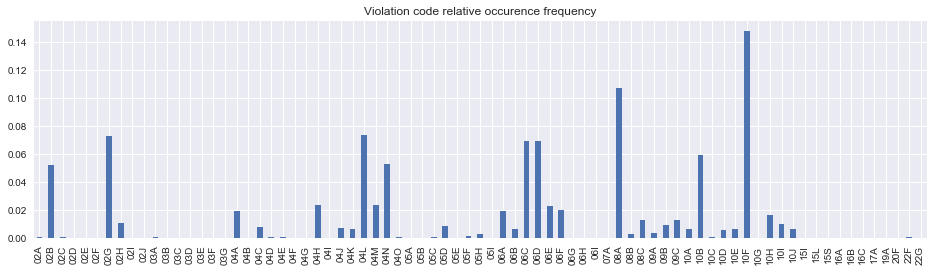

In [22]:
# Violation occurence
tmp = df2['VIOLATION CODE'].value_counts() / df2.shape[0]
tmp = tmp.sort_index()
tmp.plot(kind='bar', figsize=(16,4))
plt.title('Violation code relative occurence frequency')

In [23]:
top10_violation = df2['VIOLATION CODE'].value_counts().iloc[0:10]
top10_violation = top10_violation.to_frame('count')
top10_violation['percentage'] = top10_violation['count'] / top10_violation['count'].sum() *100
top10_violation['description'] = [vcode_dict[x] for x in top10_violation.index]
display(top10_violation)

,count,percentage,description
10F,55182,20.275052,"Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit."
08A,39950,14.678488,Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premises and/or allowing vermin to exist.
04L,27508,10.107030,Evidence of mice or live mice present in facility's food and/or non-food areas.
02G,27312,10.035015,Cold food item held above 41Âº F (smoked fish and reduced oxygen packaged foods above 38 ÂºF) except during necessary preparation.
06C,25957,9.537159,"Food not protected from potential source of contamination during storage, preparation, transportation, display or service."
06D,25875,9.507031,"Food contact surface not properly washed, rinsed and sanitized after each use and following any activity when contamination may have occurred."
10B,22223,8.165207,Plumbing not properly installed or maintained; anti-siphonage or backflow prevention device not provided where required; equipment or floor not properly drained; sewage disposal system in disrepair or not functioning properly.
04N,19767,7.262820,"Filth flies or food/refuse/sewage-associated (FRSA) flies present in facilitys food and/or non-food areas. Filth flies include house flies, little house flies, blow flies, bottle flies and flesh flies. Food/refuse/sewage-associated flies include fruit flies, drain flies and Phorid flies."
02B,19473,7.154798,Hot food item not held at or above 140Âº F.
04H,8920,3.277400,"Raw, cooked or prepared food is adulterated, contaminated, cross-contaminated, or not discarded in accordance with HACCP plan."


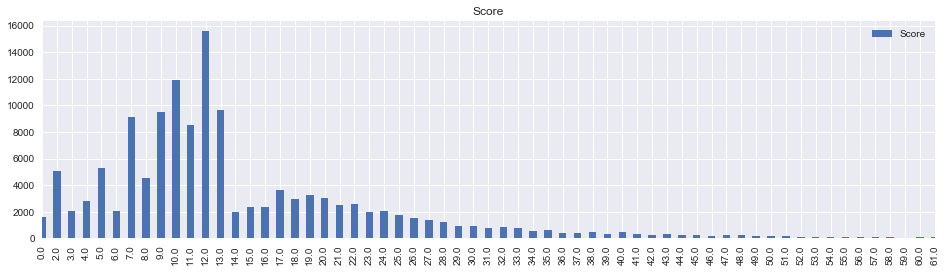

In [24]:
# Overall score distribution
tmp = new_df.SCORE.value_counts()
tmp = tmp.sort_index()
tmp = tmp.to_frame('Score')
tmp.plot(kind='bar', figsize=(16,4))
plt.xlim([0,60])
plt.title('Score')
plt.show()

In [25]:
# x1 = stats.norm.rvs(size=200, loc=0., scale=1)
# x2 = stats.norm.rvs(size=200, loc=100., scale=2)
# sm.qqplot(x1, dist=stats.norm, fit=True, line='45')
# sm.qqplot(x2, dist=stats.norm, fit=True, line='45')
# plt.show()

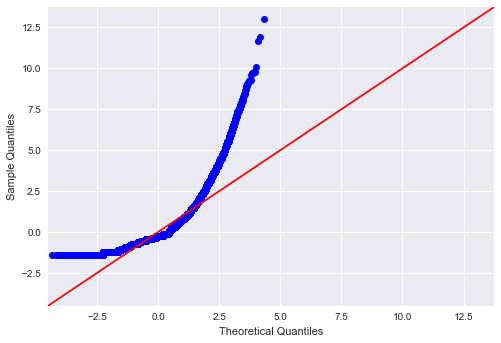

In [26]:
# certainly not looking like a normal distribution at all
score_samples = new_df.SCORE.values
sm.qqplot(score_samples, dist=stats.norm, fit=True, line='45')
plt.show()

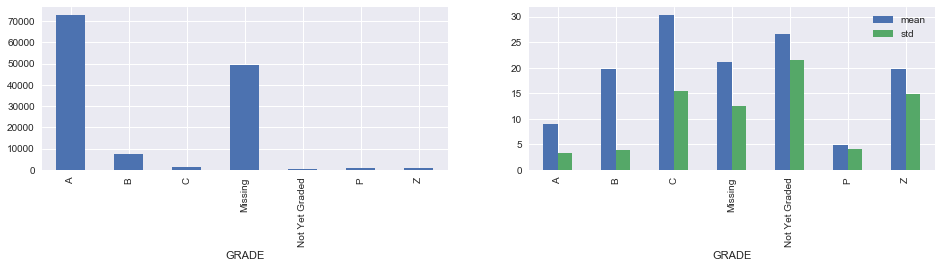

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,3))
new_df.groupby(['GRADE'])['DBA'].count().plot(kind='bar', ax=axes[0])
new_df.groupby(['GRADE'])['SCORE'].agg([np.mean, np.std]).plot(kind='bar', ax=axes[1])

Overall distribution have a notch at score == 14, I'll look into this later

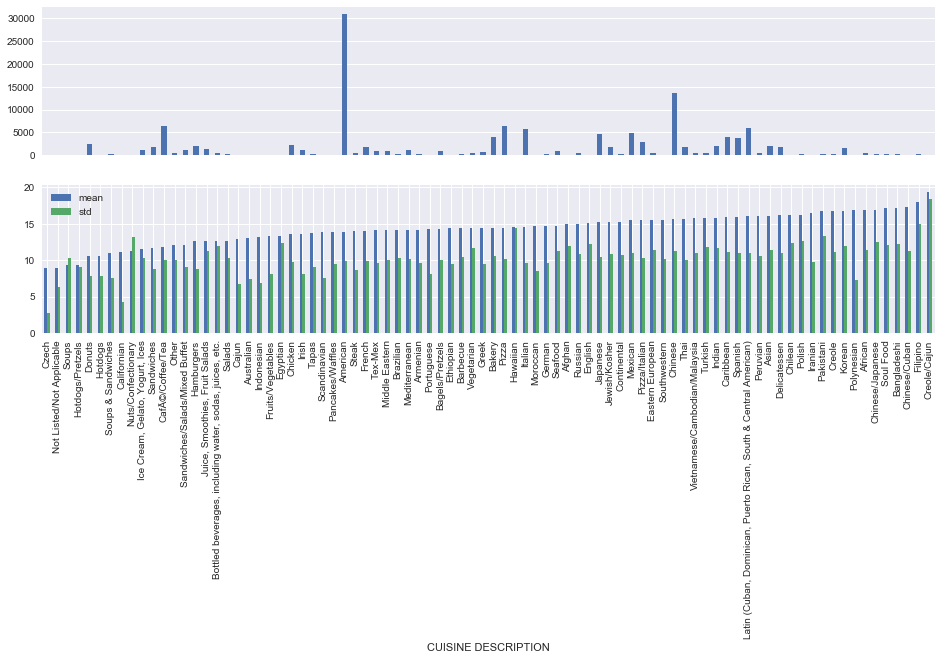

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,6))
a = new_df.groupby(['CUISINE DESCRIPTION'])['SCORE'].agg([np.mean, np.std])
a = a.sort_values(['mean'])
b = new_df.groupby(['CUISINE DESCRIPTION'])['DBA'].count()
a['count'] = b
a['count'].plot(kind='bar', ax=axes[0])
a[['mean', 'std']].plot(kind='bar', ax=axes[1])
x_axis = axes[0].axes.get_xaxis()
x_axis.set_visible(False)

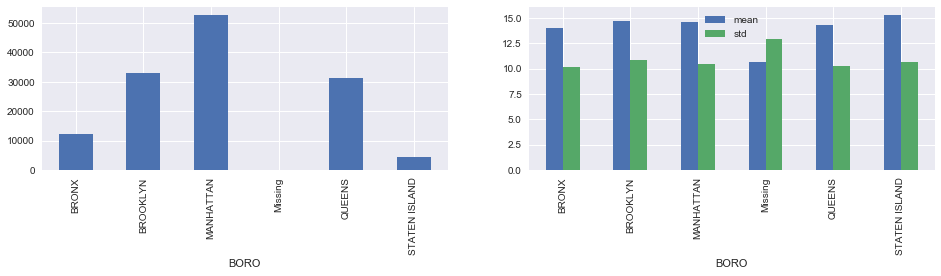

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,3))
new_df.groupby(['BORO'])['DBA'].count().plot(kind='bar', ax=axes[0])
new_df.groupby(['BORO'])['SCORE'].agg([np.mean, np.std]).plot(kind='bar', ax=axes[1])

In [30]:
g = new_df[new_df['inspection_year']>=2015].groupby(['BORO'])['SCORE']
k = sorted(list(g.groups.keys()))
k.remove('Missing')
p_matrix = pd.DataFrame(columns=k, index=k, dtype=float)
ks_matrix = pd.DataFrame(columns=k, index=k, dtype=float)
for i in k:
    for j in k:
        #if i == j:
        #    p_matrix.loc[i,j] = 0 # erase diagonal
        #    continue
        t, p = stats.ttest_ind(g.get_group(i).values, g.get_group(j).values, equal_var=False)
        p_matrix.loc[i,j] = p
        D, ksp = stats.ks_2samp(g.get_group(i).values, g.get_group(j).values)
        ks_matrix.loc[i,j] = ksp

In [31]:
g.mean()

BORO
BRONX            14.020800
BROOKLYN         14.652163
MANHATTAN        14.504723
Missing          10.666667
QUEENS           14.165642
STATEN ISLAND    15.182023
Name: SCORE, dtype: float64

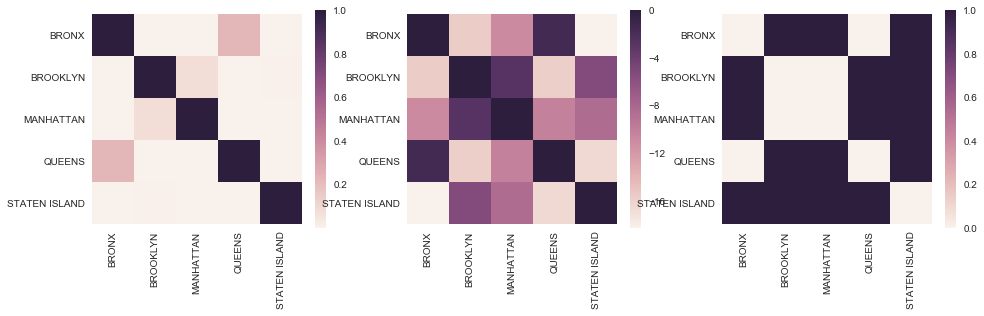

In [32]:
alpha = 0.05
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
sns.heatmap(p_matrix, square=True)
plt.subplot(1,3,2)
sns.heatmap(np.log(p_matrix), square=True)
plt.subplot(1,3,3)
sns.heatmap(p_matrix < alpha, square=True)

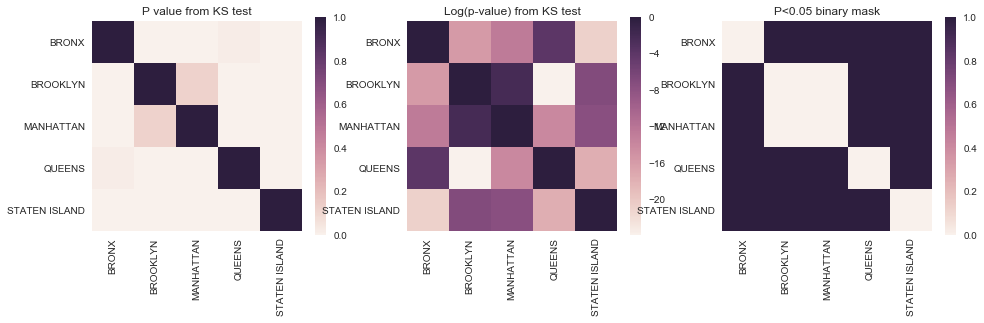

In [33]:
alpha = 0.05
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.title('P value from KS test')
sns.heatmap(ks_matrix, square=True)
plt.subplot(1,3,2)
plt.title('Log(p-value) from KS test')
sns.heatmap(np.log(ks_matrix), square=True)
plt.subplot(1,3,3)
plt.title('P<0.05 binary mask')
sns.heatmap(ks_matrix < alpha, square=True)

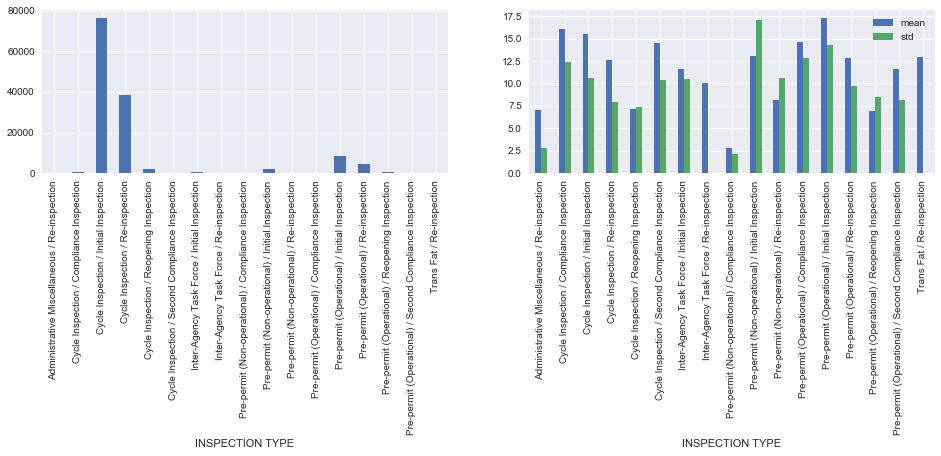

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,3))
new_df.groupby(['INSPECTION TYPE'])['DBA'].count().plot(kind='bar', ax=axes[0])
new_df.groupby(['INSPECTION TYPE'])['SCORE'].agg([np.mean, np.std]).plot(kind='bar', ax=axes[1])

(0, 90)

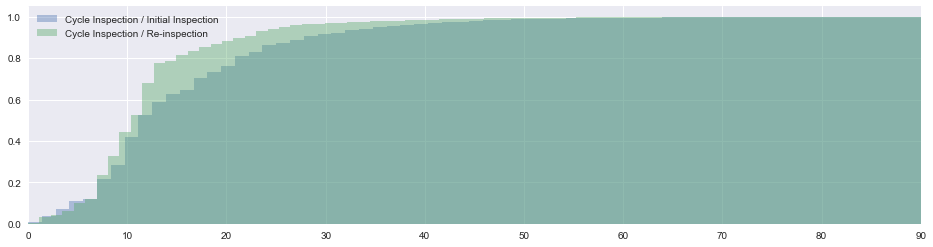

In [35]:
new_df['INSPECTION TYPE'].value_counts()
top_type = new_df['INSPECTION TYPE'].value_counts().index[:2]
plt.figure(figsize=(16, 4))
n=1
for b in top_type:
    score = new_df[new_df['INSPECTION TYPE']==b].SCORE.values
    plt.hist(score, normed=True, bins=100, cumulative=True, alpha=0.4)
plt.legend(top_type)
plt.xlim([0,90])

In [36]:
# checking KS 
print(stats.ks_2samp(new_df[new_df['INSPECTION TYPE']==top_type[0]].SCORE.values, 
                   new_df[new_df['INSPECTION TYPE']==top_type[1]].SCORE.values))

Ks_2sampResult(statistic=0.18466598617008267, pvalue=0.0)


In [37]:
# iterate through a few subsamples
ks_p = []
N_sample = 1000
for i in range(10):
    _, p = stats.ks_2samp(new_df[new_df['INSPECTION TYPE']==top_type[0]].sample(N_sample).SCORE.values, 
                          new_df[new_df['INSPECTION TYPE']==top_type[1]].sample(N_sample).SCORE.values)
    ks_p.append(p)
ks_p = np.array(ks_p)
print(ks_p.mean(), ks_p.std())

4.87721811894e-11 1.43907448443e-10


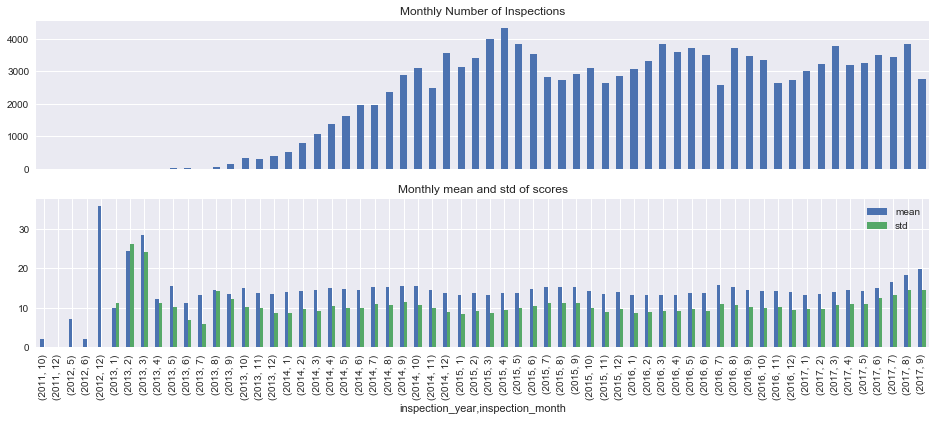

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,6))
new_df.groupby(['inspection_year', 'inspection_month'])['DBA'].count().plot(kind='bar', 
                                                                            title='Monthly Number of Inspections',
                                                                            ax=axes[0])
new_df.groupby(['inspection_year', 'inspection_month'])['SCORE'].agg([np.mean, np.std]).plot(kind='bar', 
                                                                                             title='Monthly mean and std of scores',
                                                                                             ax=axes[1])
x_axis = axes[0].axes.get_xaxis()
x_axis.set_visible(False)

In [39]:
# cc = new_df.groupby(['inspection_year', 'inspection_month'])['GRADE'].value_counts()
# cc.unstack(['GRADE'])[['A', 'B', 'C']].plot(kind='bar', figsize=(16,3))

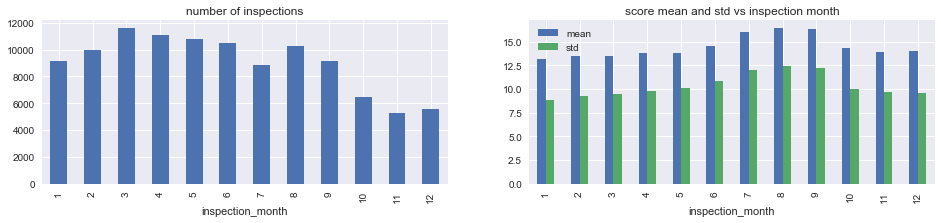

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,3))
new_df[new_df['inspection_year']>=2015].groupby(['inspection_month'])['DBA'].count().plot(kind='bar', ax=axes[0], title='number of inspections')
new_df[new_df['inspection_year']>=2015].groupby(['inspection_month'])['SCORE'].agg([np.mean, np.std]).plot(kind='bar', ax=axes[1], title='score mean and std vs inspection month')

In [41]:
g = new_df[new_df['inspection_year']>=2015].groupby(['inspection_month'])['SCORE']
#print(g.mean())
t, p = stats.ttest_ind(g.get_group(2).values, g.get_group(3).values, equal_var=False)
print(t,p)
t, p = stats.ttest_ind(g.get_group(2).values, g.get_group(4).values, equal_var=False)
print(t,p)
t, p = stats.ttest_ind(g.get_group(2).values, g.get_group(7).values, equal_var=False)
print(t,p)

0.58459164045 0.558828549395
-1.95745739561 0.0503069322005
-15.5641301239 3.09242064421e-54


In [42]:
k = sorted(list(g.groups.keys()))
p_matrix = pd.DataFrame(columns=k, index=k, dtype=float)
ks_matrix = pd.DataFrame(columns=k, index=k, dtype=float)
for i in k:
    for j in k:
        #if i == j:
        #    p_matrix.loc[i,j] = 0 # erase diagonal
        #    continue
        t, p = stats.ttest_ind(g.get_group(i).values, g.get_group(j).values, equal_var=False)
        p_matrix.loc[i,j] = p
        D, ksp = stats.ks_2samp(g.get_group(i).values, g.get_group(j).values)
        ks_matrix.loc[i,j] = ksp

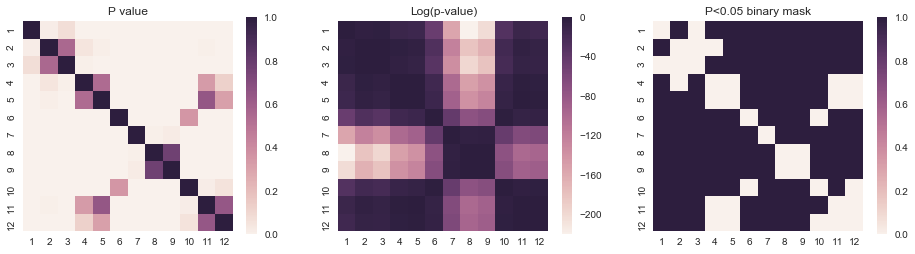

In [43]:
alpha = 0.05
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.title('P value')
sns.heatmap(p_matrix, square=True)
plt.subplot(1,3,2)
plt.title('Log(p-value)')
sns.heatmap(np.log(p_matrix), square=True)
plt.subplot(1,3,3)
plt.title('P<0.05 binary mask')
sns.heatmap(p_matrix < alpha, square=True)

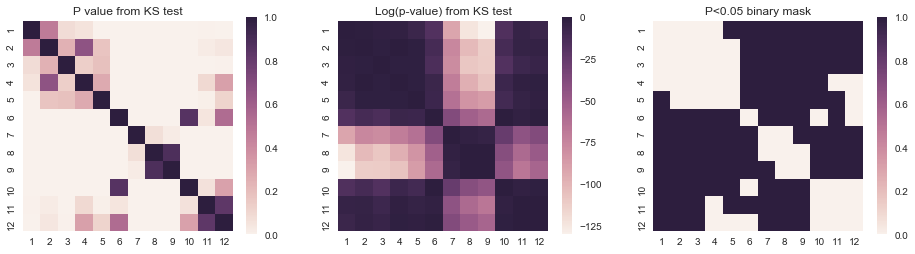

In [44]:
alpha = 0.05
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.title('P value from KS test')
sns.heatmap(ks_matrix, square=True)
plt.subplot(1,3,2)
plt.title('Log(p-value) from KS test')
sns.heatmap(np.log(ks_matrix), square=True)
plt.subplot(1,3,3)
plt.title('P<0.05 binary mask')
sns.heatmap(ks_matrix < alpha, square=True)

In [45]:
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
# new_df.groupby(['inspection_day'])['DBA'].count().plot(kind='bar', ax=axes[0])
# new_df.groupby(['inspection_day'])['SCORE'].agg([np.mean, np.std]).plot(kind='bar', ax=axes[1])

In [46]:
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
# new_df.groupby(['inspection_weekday'])['DBA'].count().plot(kind='bar', ax=axes[0])
# new_df.groupby(['inspection_weekday'])['SCORE'].agg([np.mean, np.std]).plot(kind='bar', ax=axes[1])

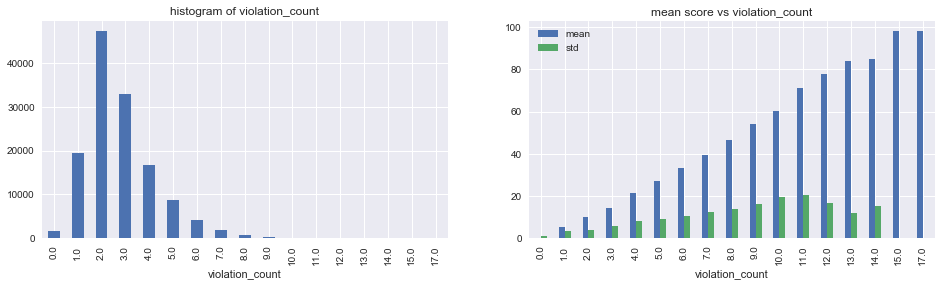

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
new_df.groupby(['violation_count'])['DBA'].count().plot(kind='bar', ax=axes[0], title='histogram of violation_count')
new_df.groupby(['violation_count'])['SCORE'].agg([np.mean, np.std]).plot(kind='bar', ax=axes[1], title='mean score vs violation_count')

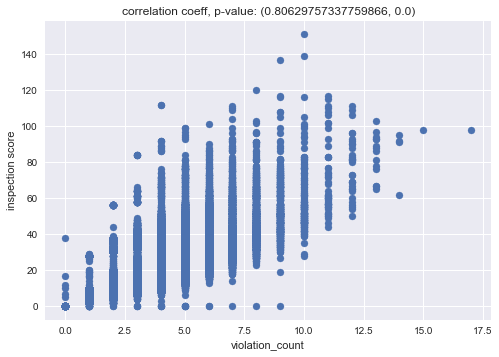

In [48]:
# scores seem to be linearyly correlated with violation_count
score = new_df['SCORE'].values
vcount = new_df['violation_count'].values
plt.scatter(vcount, score)
plt.xlabel('violation_count')
plt.ylabel('inspection score')
plt.title('correlation coeff, p-value: ' + str(stats.pearsonr(score, vcount)))

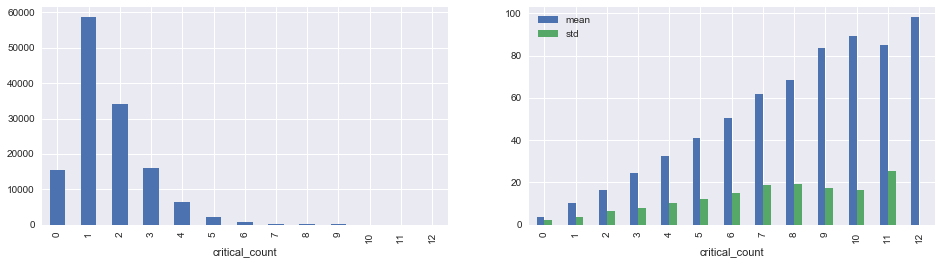

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
new_df.groupby(['critical_count'])['DBA'].count().plot(kind='bar', ax=axes[0])
new_df.groupby(['critical_count'])['SCORE'].agg([np.mean, np.std]).plot(kind='bar', ax=axes[1])

correlation coeff, p-value:  (0.83084338858953755, 0.0)


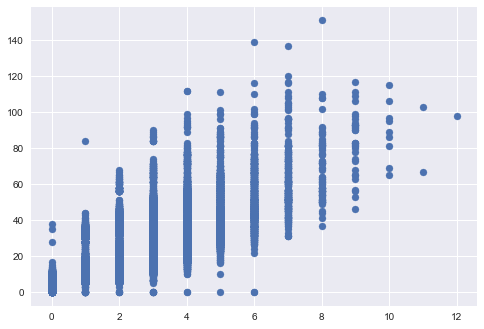

In [50]:
# scores seem to also be linearyly correlated with critical_count
score = new_df['SCORE'].values
ccount = new_df['critical_count'].values
plt.scatter(ccount, score)
print('correlation coeff, p-value: ', stats.pearsonr(score, ccount))

In [51]:
top_food = list(new_df['CUISINE DESCRIPTION'].value_counts().index[:8])  # top cuisine categories
top_food.append('Seafood')  # just curious about seafood...

# Modeling

In [53]:
violation_codes = violation_codes[:-3]

In [54]:
a = new_df[violation_codes].astype(float).corr()

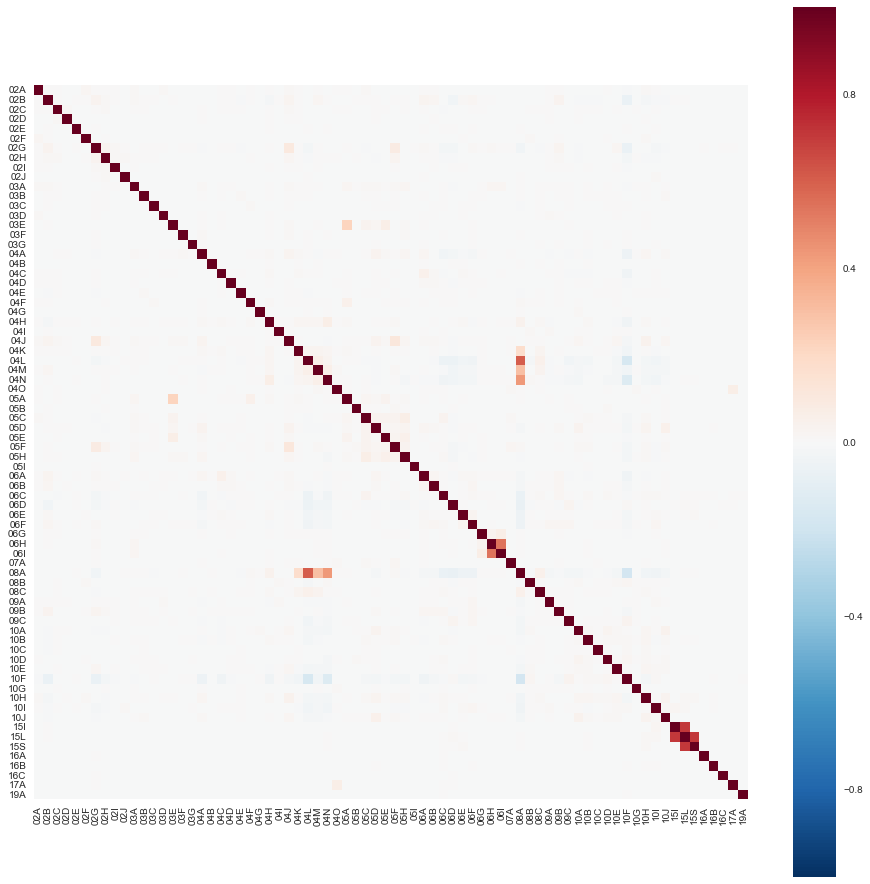

In [55]:
plt.figure(figsize=(16,16))
sns.heatmap(a, square=True)

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import ElasticNet, ElasticNetCV, Lasso, LassoCV, LinearRegression

In [57]:
y = new_df['SCORE'].values

In [58]:
y.shape

(133777,)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
reg = LassoCV(eps=0.0001, random_state=0, positive=True)
reg.fit (X_train, y_train)
y_pred = reg.predict(X_test)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))
coeff1 = reg.coef_

Mean squared error: 16.05
Variance score: 0.85


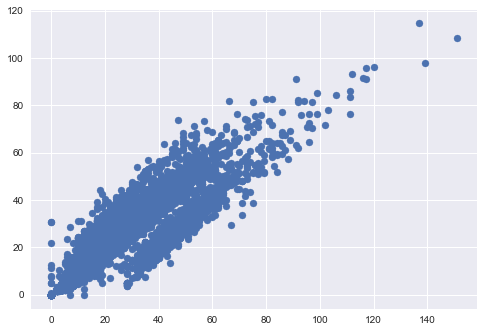

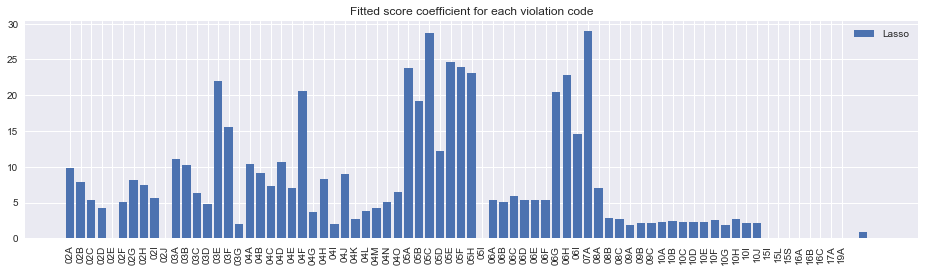

In [60]:
plt.scatter(y_test, y_pred)
plt.show()
plt.figure(figsize=(16,4))
#plt.plot(coeff0)
plt.bar(np.arange(0, len(coeff1)), coeff1)
#plt.plot(coeff2)
plt.xticks(np.arange(0, len(violation_codes), dtype=int), violation_codes, rotation='vertical')
plt.legend(['Lasso']) #, 'ElasticNet'])
plt.title('Fitted score coefficient for each violation code')
plt.show()

In [61]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                 1.030e+04
Date:                Sun, 01 Oct 2017   Prob (F-statistic):               0.00
Time:                        22:02:34   Log-Likelihood:            -3.7519e+05
No. Observations:              133777   AIC:                         7.505e+05
Df Residuals:                  133700   BIC:                         7.513e+05
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2466      0.025    -10.043      0.0

In [62]:
from sklearn import preprocessing

In [63]:
feature_names = violation_codes.copy()
le_inspect_type = preprocessing.LabelEncoder()
le_inspect_type.fit(new_df['INSPECTION TYPE'])
feature_names.append('INSPECTION TYPE')
X2 = np.hstack([X, np.reshape(le_inspect_type.transform(new_df['INSPECTION TYPE']), (-1, 1))])

le_boro = preprocessing.LabelEncoder()
le_boro.fit(new_df['BORO'])
feature_names.append('BORO')
X2 = np.hstack([X2, np.reshape(le_boro.transform(new_df['BORO']), (-1, 1))])

le_food = preprocessing.LabelEncoder()
le_food.fit(new_df['CUISINE DESCRIPTION'])
feature_names.append('CUISINE DESCRIPTION')
X2 = np.hstack([X2, np.reshape(le_food.transform(new_df['CUISINE DESCRIPTION']), (-1, 1))])

# le_grade = preprocessing.LabelEncoder()
# le_grade.fit(new_df['GRADE'])
# feature_names.append('GRADE')
# X2 = np.hstack([X2, np.reshape(le_grade.transform(new_df['GRADE']), (-1, 1))])

feature_names.append('violation_count')
X2 = np.hstack([X2, np.reshape(new_df['violation_count'].astype(float).values, (-1, 1))])

feature_names.append('critical_count')
X2 = np.hstack([X2, np.reshape(new_df['critical_count'].astype(float).values, (-1, 1))])

feature_names.append('inspection_month')
X2 = np.hstack([X2, np.reshape(new_df['inspection_month'].astype(float).values, (-1, 1))])

feature_names.append('inspection_year')
X2 = np.hstack([X2, np.reshape(new_df['inspection_year'].astype(float).values, (-1, 1))])

feature_names.append('inspection_day')
X2 = np.hstack([X2, np.reshape(new_df['inspection_day'].astype(float).values, (-1, 1))])

feature_names.append('inspection_weekday')
X2 = np.hstack([X2, np.reshape(new_df['inspection_weekday'].astype(float).values, (-1, 1))])


feature_names.append('ZIPCODE')
X2 = np.hstack([X2, np.reshape(new_df['ZIPCODE'].astype(float).values, (-1, 1))])

# feature_names.append('CAMIS')
# X2 = np.hstack([X2, np.reshape(new_df['CAMIS'].astype(float).values, (-1, 1))])

In [64]:
#X2=X2[:,77:]
#feature_names=feature_names[77:]

In [65]:
print(X2.shape, len(feature_names))

(133777, 87) 84


In [66]:
import xgboost as xgb

In [67]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.33, random_state=42)
xgb_model = xgb.XGBRegressor(
    learning_rate =0.1,
    silent=False,
    n_estimators=200,
    max_depth=4,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    nthread=4,
    scale_pos_weight=1,
    seed=0).fit(X2_train,y2_train)
y2_pred = xgb_model.predict(X2_test)
print(mean_squared_error(y2_pred, y2_test))

15.096996435


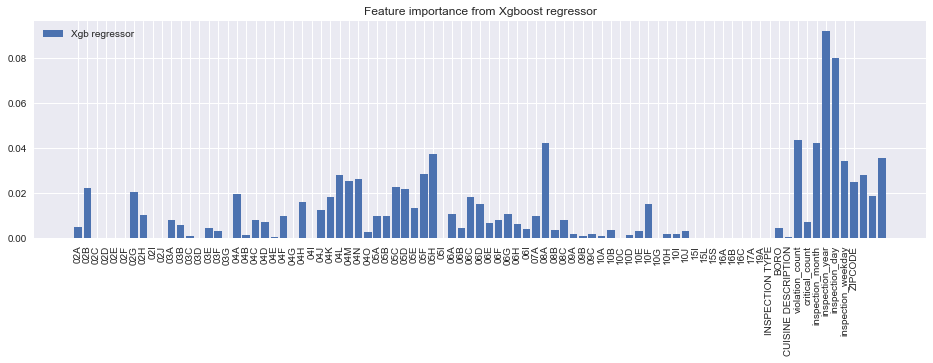

In [68]:
plt.figure(figsize=(16,4))
imp = xgb_model.feature_importances_
plt.bar(np.arange(0, len(imp)), imp)
plt.xticks(np.arange(0, len(feature_names), dtype=int), feature_names, rotation='vertical')
plt.legend(['Xgb regressor'])
plt.title('Feature importance from Xgboost regressor')
plt.show()